# Week 3 Jupyter Notebook — Linear Regression 3
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, Semester Two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data, using the methods you have learned about in this course and in this program, and draw interesting conclusions. 

For Week 3, include concepts such as linear regression with forward and backward selection, PCR, and PLSR. 

In [228]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression


In [229]:
#load data
df = pd.read_csv("Kaggle_Home_Credit_Default_Risk__train.csv")

#added to print the current row count since we will want to confirm if filtering or dropping actually removed items and how many
print("iinitial row count:", df.shape[0])


iinitial row count: 307511


In [230]:
#removed out the placeholder of 365243; it appears this value is used when a person is unemployed, retired, earning passive income, etc. 
df_filtered = df[df['DAYS_EMPLOYED'] != 365243].copy()
print("rows AFTER removing days employed/placeholder:", df_filtered.shape[0])

rows AFTER removing days employed/placeholder: 252137


In [231]:
#convert values that were negative to positive (age, employment duration)
df_filtered['DAYS_BIRTH'] = df_filtered['DAYS_BIRTH'].abs()
df_filtered['DAYS_EMPLOYED'] = df_filtered['DAYS_EMPLOYED'].abs()
print(df_filtered.isnull().sum())

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     33856
AMT_REQ_CREDIT_BUREAU_WEEK    33856
AMT_REQ_CREDIT_BUREAU_MON     33856
AMT_REQ_CREDIT_BUREAU_QRT     33856
AMT_REQ_CREDIT_BUREAU_YEAR    33856
Length: 122, dtype: int64


In [232]:
#add additional features for Week 3 -- these will be used for modeling
selected_columns = [
    'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
    'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'REGION_POPULATION_RELATIVE', 'TARGET'  
]

#confirm # of rows 
print("Rows BEFORE dropping missing:", df_filtered.shape[0])


Rows BEFORE dropping missing: 252137


In [233]:
#drop rows with missing values in indicated columns
df_filtered = df_filtered[selected_columns].dropna()

#confirm updated shape AFTER cleaning
print("Rows after dropping missing:", df_filtered.shape[0])

Rows after dropping missing: 98859


In [234]:
#confirm if any missing values
print("Nulls after drop:", df_filtered.isnull().sum().sum())

Nulls after drop: 0


In [235]:
## Prepped data -- Now ready for modeling
#per instructions, need to complete 3 modeling techniques:
#1 - Forward and Backward Feature Selection using Linear Regression
#2 - Principal Component Regression (PCR)
#3 - Partial Least Squares Regression (PLSR)

In [236]:
## FORWARD SELECTION
#create a list of features --- make sure to exclude TARGET
features = df_filtered.columns.tolist()
features.remove('TARGET')

#establish target/baseline model
y = df_filtered['TARGET']
X = df_filtered[features]

#add function for forward selection
def forward_selection(X, y):
    initial_features = []
    best_features = []
    remaining_features = list(X.columns)
    current_score, best_new_score = float('inf'), float('inf')

    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            try_features = initial_features + [candidate]
            X_train = sm.add_constant(X[try_features])
            model = sm.OLS(y, X_train).fit()
            aic = model.aic
            scores_with_candidates.append((aic, candidate))

        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]

        if current_score > best_new_score:
            remaining_features.remove(best_candidate)
            initial_features.append(best_candidate)
            current_score = best_new_score
            best_features = initial_features.copy()
        else:
            break

    return best_features

#run forward selection
selected_features = forward_selection(X, y)
print("output of features using forward selection:", selected_features)


output of features using forward selection: ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE']


The outpuit from the forward selection are: 

- EXT_SOURCE_1/2/3: External risk scores; are often highly predictive of default.
- DAYS_BIRTH, DAYS_EMPLOYED: Applicant age, work history.
- AMT_*: Financial details like credit, annuity, income.
- REGION_POPULATION_RELATIVE: May capture access to financial services or competition.
- EXT_SOURCE_1/2/3: External risk scores; often indicates predictive of default.
- DAYS_BIRTH, DAYS_EMPLOYED: Applicant age, work history.
- AMT_*: Financial details like credit, annuity, income.
- REGION_POPULATION_RELATIVE: can capture access to financial services or competition.



In [237]:
## BACKYARD SELECTION 

#define backward selection func
def backward_selection(X, y):
    features = X.columns.tolist()
    best_features = features.copy()
    current_score = sm.OLS(y, sm.add_constant(X[features])).fit().aic

    while len(best_features) > 0:
        scores_with_candidates = []

        for candidate in best_features:
            temp_features = best_features.copy()
            temp_features.remove(candidate)
            model = sm.OLS(y, sm.add_constant(X[temp_features])).fit()
            aic = model.aic
            scores_with_candidates.append((aic, candidate))

        scores_with_candidates.sort()
        best_new_score, worst_feature = scores_with_candidates[0]

        if best_new_score < current_score:
            best_features.remove(worst_feature)
            current_score = best_new_score
        else:
            break

    return best_features


#now run backward selection on the same X and y
selected_backward = backward_selection(X, y)

print("features selected: backward selection:")
print(selected_backward)


features selected: backward selection:
['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_POPULATION_RELATIVE']


Both forward & backwards selection selected the same 10 features, just in different order

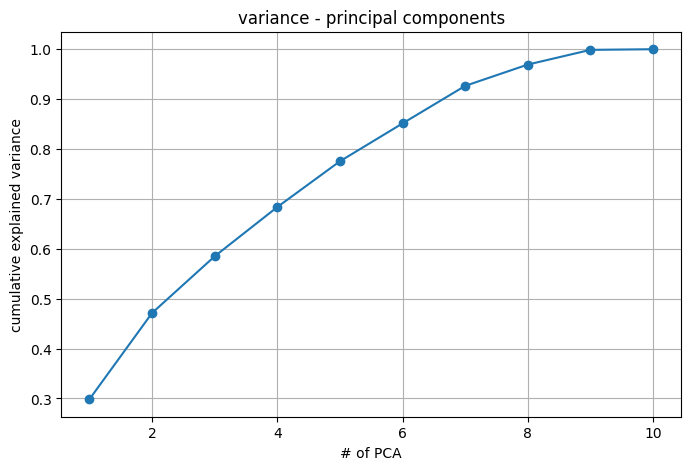

In [238]:
## PCA --  feature transformation + variance plot

#leverage features selected from forward/backward selection. x = same selected features. y = target variable
X = df_filtered[selected_backward].copy()  
y = df_filtered['TARGET']                 

#use scaler to standardize the features (BEFORE running PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#aply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#verify variance each component explains
explained_var = np.cumsum(pca.explained_variance_ratio_)

#plot variance -- will help us determind how many and which components to keep
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('# of PCA')
plt.ylabel('cumulative explained variance')
plt.title('variance - principal components')
plt.grid(True)
plt.show()


The first 6 to 8 components explain about 90–95% of the total variance, which is a good threshold for modeling without too much loss of information.

In [239]:
## PCR


#need to run linear regression using principal components (from PCA) instead of the original features. This helps reduce multicollinearity, improve model generalization.
#identify # principal components to keep from PCA. looks like 6-8 is ideal, so we will use 8
n_components = 8

#reduce features using PCA
#creates a new matrix (X_pca_reduced) with 8 components instead of the full feature set.
X_pca_reduced = X_pca[:, :n_components]

#split trainging vs. test set
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

#train linear regression on the principal components
model_pcr = LinearRegression()
model_pcr.fit(X_train, y_train)

#predict on TEST data
y_pred = model_pcr.predict(X_test)

#eval model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"PCR RMSE: {rmse:.4f}")
print(f"PCR R² Score: {r2:.4f}")


PCR RMSE: 0.2643
PCR R² Score: 0.0607


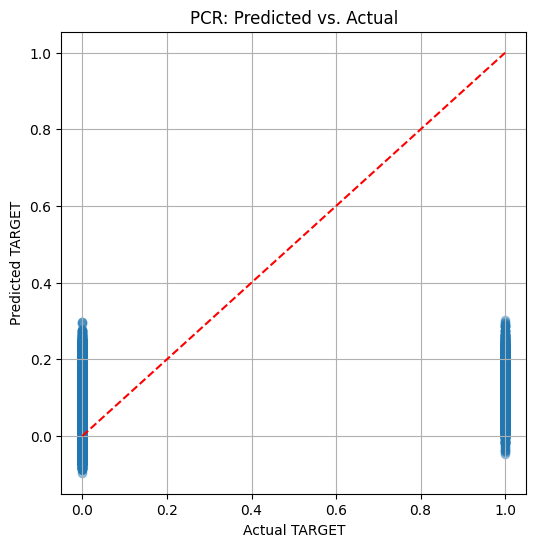

In [240]:
#plot predicted vs. actual output
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], '--r')  # reference line
plt.xlabel("Actual TARGET")
plt.ylabel("Predicted TARGET")
plt.title("PCR: Predicted vs. Actual")
plt.grid(True)
plt.show()

In [241]:
## FORWARD SELECTION

X_forward = df_filtered[selected_features].copy()
y = df_filtered['TARGET']

#train/test split
X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = train_test_split(X_forward, y, test_size=0.2, random_state=42)

#train model
model_fwd = LinearRegression()
model_fwd.fit(X_train_fwd, y_train_fwd)

#predict
y_pred_fwd = model_fwd.predict(X_test_fwd)

#petrics
rmse_fwd = np.sqrt(mean_squared_error(y_test_fwd, y_pred_fwd))
r2_fwd = r2_score(y_test_fwd, y_pred_fwd)

print(f"Forward Selection RMSE: {rmse_fwd:.4f}")
print(f"Forward Selection R²: {r2_fwd:.4f}")


Forward Selection RMSE: 0.2639
Forward Selection R²: 0.0639


In [242]:
## BACKWARD SELECTION 

X_backward = df_filtered[selected_backward].copy()

X_train_bwd, X_test_bwd, y_train_bwd, y_test_bwd = train_test_split(X_backward, y, test_size=0.2, random_state=42)

model_bwd = LinearRegression()
model_bwd.fit(X_train_bwd, y_train_bwd)

y_pred_bwd = model_bwd.predict(X_test_bwd)

rmse_bwd = np.sqrt(mean_squared_error(y_test_bwd, y_pred_bwd))
r2_bwd = r2_score(y_test_bwd, y_pred_bwd)

print(f"Backward Selection RMSE: {rmse_bwd:.4f}")
print(f"Backward Selection R²: {r2_bwd:.4f}")

Backward Selection RMSE: 0.2639
Backward Selection R²: 0.0639


In [243]:
## PCR -- WITH 8 COMPONENTS 

#use 1st 8 principal components
X_pcr = X_pca[:, :8]  # assuming you've stored pca output as X_pca earlier

#train/test split
X_train_pcr, X_test_pcr, y_train_pcr, y_test_pcr = train_test_split(X_pcr, y, test_size=0.2, random_state=42)

#fit linear regression
model_pcr = LinearRegression()
model_pcr.fit(X_train_pcr, y_train_pcr)

#predict/eval
y_pred_pcr = model_pcr.predict(X_test_pcr)
rmse_pcr = np.sqrt(mean_squared_error(y_test_pcr, y_pred_pcr))
r2_pcr = r2_score(y_test_pcr, y_pred_pcr)

print(f"PCR RMSE: {rmse_pcr:.4f}")
print(f"PCR R/2 Score: {r2_pcr:.4f}")


PCR RMSE: 0.2643
PCR R/2 Score: 0.0607


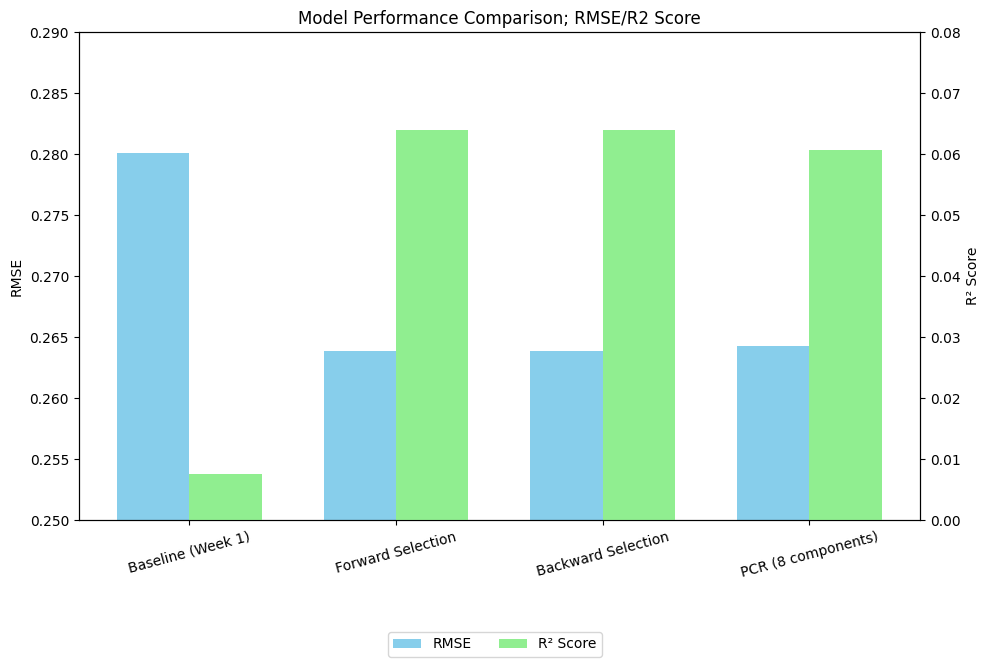

In [244]:
## Visual / chart - summary

#list model names and metrics
models = ['Baseline (Week 1)', 'Forward Selection', 'Backward Selection', 'PCR (8 components)']
rmse = [0.2801, 0.2639, 0.2639, 0.2643]
r2 = [0.0076, 0.0639, 0.0639, 0.0607]

#plot settings
x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

#plot RMSE
bar1 = ax1.bar(x - width/2, rmse, width, label='RMSE', color='skyblue')
ax1.set_ylabel('RMSE')
ax1.set_ylim(0.25, 0.29)
ax1.set_title('Model Performance Comparison; RMSE/R2 Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15)

#create a 2ndy-axis for R²
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, r2, width, label='R² Score', color='lightgreen')
ax2.set_ylabel('R² Score')
ax2.set_ylim(0, 0.08)

#legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()


## Week 3 Summary / Draft (prior to PLSR)

### I accidentally forgot to include the PLSR section; adding it now and updating the conclusion below

### Prep of data and features 

Started by reloading and cleaning the dataset from Week 2. Key steps included:

- Removing placeholder values in DAYS_EMPLOYED; value = 365243.
- Converting DAYS_BIRTH and DAYS_EMPLOYED to positive values for interpretability.
- Selecting a wider set of candidate features based on domain knowledge and Week 2 experiments.
- Removing rows with missing values from the selected subset to ensure consistency.

### Model Selection -- forward, backward

We implemented forward selection and backward elimination (leveraging Akaike Information Criterion (AIC) - not required, but helpful to guide feature inclusion or exclusion -- helps explain how model selection can be guided by fit. Additional info: https://www.scribbr.com/statistics/akaike-information-criterion). This allowed me to reduce overfitting by avoiding unhelpful predictors.

- Forward Selection Output:


  ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
   'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 
   'REGION_POPULATION_RELATIVE']


### Model Performance comparison

| Model                  | RMSE   | R² Score | Notes                                            |
| ----------------------|--------|----------|--------------------------------------------------|
| **Baseline (Week 1)** | 0.2801 | 0.0076   | No feature selection or dimensionality reduction |
| **Forward Selection** | 0.2639 | 0.0639   | AIC-based; efficient and interpretable           |
| **Backward Selection**| 0.2639 | 0.0639   | Same result as forward this time                 |
| **PCR (8 components)**| 0.2643 | 0.0607   | Slightly worse than selection-based models       |



In [245]:
### Partial Least Squares Regression -- PLSR
### Added PLSR 

# prep data using the features from backward selection
X_plsr_raw = df_filtered[selected_backward].copy()
y_plsr = df_filtered['TARGET']

#standardize features
scaler = StandardScaler()
X_plsr_scaled = scaler.fit_transform(X_plsr_raw)


#split train/test data
X_train_plsr, X_test_plsr, y_train_plsr, y_test_plsr = train_test_split(
    X_plsr_scaled, y_plsr, test_size=0.2, random_state=42)

#set up the PLS Regression model with 6 components
pls = PLSRegression(n_components=6)
pls.fit(X_train_plsr, y_train_plsr)

#time to predict/eval 
y_pred_plsr = pls.predict(X_test_plsr)
rmse_plsr = np.sqrt(mean_squared_error(y_test_plsr, y_pred_plsr))
r2_plsr = r2_score(y_test_plsr, y_pred_plsr)

print(f"PLSR RMSE is {rmse_plsr:.4f}")
print(f"PLSR R² score is {r2_plsr:.4f}")


PLSR RMSE is 0.2640
PLSR R² score is 0.0627


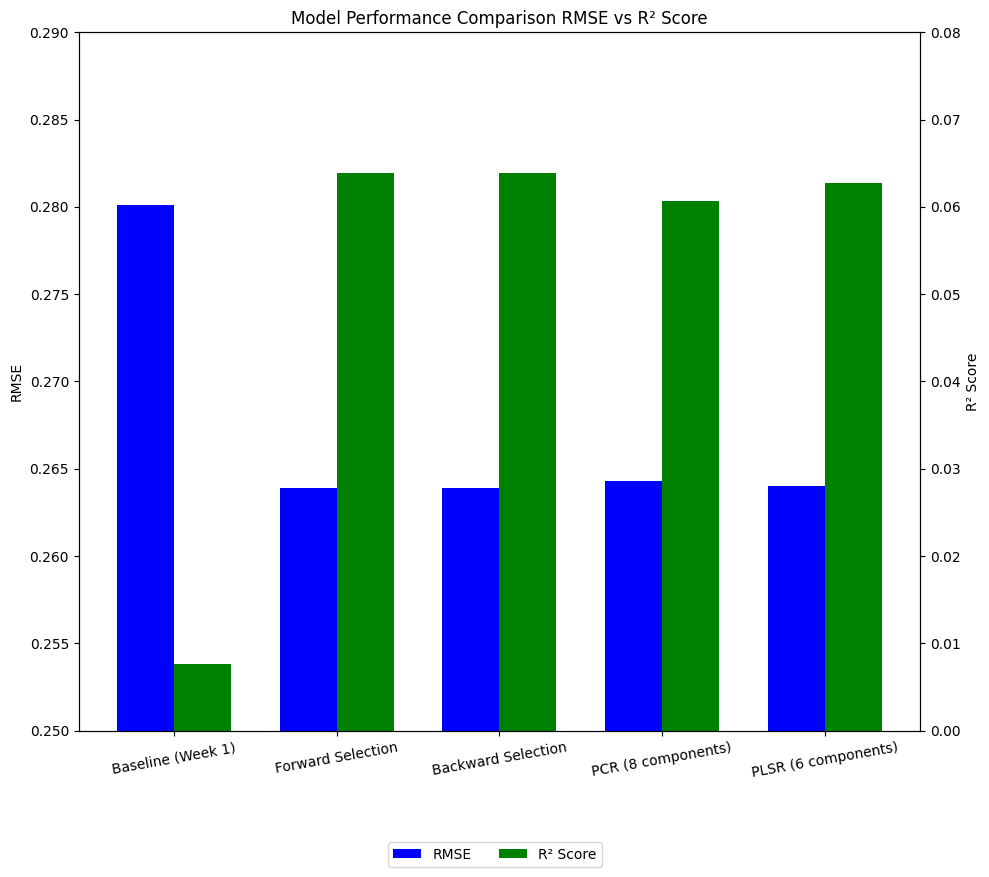

In [246]:
#updated model names/metrics to include PLSR
models = ['Baseline (Week 1)', 'Forward Selection', 'Backward Selection', 'PCR (8 components)', 'PLSR (6 components)']
rmse = [0.2801, 0.2639, 0.2639, 0.2643, 0.2640]
r2 = [0.0076, 0.0639, 0.0639, 0.0607, 0.0627]

#plot settings
x = np.arange(len(models))
width = 0.35
fig, ax1 = plt.subplots(figsize=(10, 8))

#plot RMSE
bar1 = ax1.bar(x - width/2, rmse, width, label='RMSE', color='blue')
ax1.set_ylabel('RMSE')
ax1.set_ylim([0.25, 0.29])
ax1.set_title('Model Performance Comparison RMSE vs R² Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=10)

#create second y-axis for R2
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, r2, width, label='R² Score', color='green')
ax2.set_ylabel('R² Score')
ax2.set_ylim([0.0, 0.08])

#legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()


## Week 3 Summary / Conclusion (Final)

Worked on expanded our linear modeling techniques to include model selection and dimensionality reduction, to try to improve predictive performance on the default risk dataset.

### Preparation - of data and features 

I relaoded and cleaned the dataset from Week 2, which included: 

- Removing placeholder values in DAYS_EMPLOYED; value = 365243.
- Converting DAYS_BIRTH and DAYS_EMPLOYED to positive values (better for interpreting outputs).
- Selecting a wider set of features based on domain knowledge and Week 2 review.
- Removing rows with missing values from the selected subset to ensure consistency.

### Model Selection -- forward, backward

I used Forward Selection and Backward Elimination, both using Akaike Information Criterion (AIC) as the stopping metric. While not required, AIC helped demonstrate how model fit and complexity can guide inclusion/exclusion of features. Additional info: https://www.scribbr.com/statistics/akaike-information-criterion). This allowed me to reduce overfitting by avoiding unhelpful predictors.

- Both selection methods identified the same 10 predictors:
  ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
   'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 
   'REGION_POPULATION_RELATIVE']

These models significantly improved R² compared to the Week 1 baseline and reduced RMSE.

### Model Performance comparison

| Model                  | RMSE   | R² Score | Notes                                            |
|------------------------|--------|----------|--------------------------------------------------|
| **Baseline (Week 1)**  | 0.2801 | 0.0076   | No feature selection or dimensionality reduction        |
| **Forward Selection**  | 0.2639 | 0.0639   | Used AIC to select 10 predictive features               |
| **Backward Selection** | 0.2639 | 0.0639   | Same result as forward this time                        |
| **PCR (8 components)** | 0.2643 | 0.0607   | Slightly worse than selection-based models              |
| **PLSR (6 components)**| 0.2640 | 0.0627   | Better than PCR; combines feataures with correlation    |




